In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *
DATA_DIR = '/work/users/k/4/k4thryn/Repos/OLD_EpSampling_Nov2024/data/'

from epsampling.modeling import *

from IPython.display import Audio
def allDone():
    display(Audio(filename='../cat_meow2.wav', autoplay=True))

import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('max_colwidth', None)

### <font color=blue> Poisson-based General Linear Model
- Poisson regression is often used for count or rate prediction. However, if the predictions are based in different contexts (e.g. timeframes, populations) then an offset is required to bring all predictions into the same prediction space. That is what we are doing here. 
    
    <font color=blue>
    
### &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; <font color=blue> $ log( \mathbb{E}(y)) = b_0 + b_1 x + \dots + b_n + log(P) $
<!--     </font> -->
<!--     <br> -->
        
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; where $b_1$ is state deaths and $P$ is the population of the county.
    
    

    

    

# <font color=blue> 1) Dataset

In [2]:
ts = '20241108-123515'
DATA_DIR = '/work/users/k/4/k4thryn/Repos/OLD_EpSampling_Nov2024/data/'

fpath = os.path.join(DATA_DIR,'processed',f'training_target_df_{ts}.csv')
dff = pd.read_csv(fpath)

pd.set_option('display.max_columns', None)

d = {'Proj_state_inc_deaths':'PROJ state deaths',
     'True_county_inc_deaths':'TRUE county deaths',
     'Pop':'County population',
     'Naive_proj_deaths':'Naive PROJ deaths',
    }

dff.rename(d,axis=1,inplace=True)

Y_COL = 'TRUE county deaths'
X_COLS = ['PROJ state deaths'] #,'County population']
OFFSET_COL = 'County population'
NAIVE_COL = 'Naive PROJ deaths'

dff.dropna(inplace=True)
df = dff[dff[Y_COL] >= 0]

In [3]:
df = get_model_df(df, X_COLS, Y_COL, NAIVE_COL, OFFSET_COL)
display(df)

,Date,Fips,PROJ state deaths,TRUE county deaths,Naive PROJ deaths,County population
11,20200905,37001,157.0,0.0,2.562167,169185
12,20200912,37001,176.0,2.0,2.872239,169185
13,20200919,37001,157.0,0.0,2.562167,169185
14,20200926,37001,171.0,6.0,2.790641,169185
15,20201003,37001,171.0,2.0,2.790641,169185
...,...,...,...,...,...,...
9895,20220409,37199,55.0,0.0,0.097389,18357
9896,20220416,37199,41.0,0.0,0.072599,18357
9897,20220423,37199,60.0,0.0,0.106243,18357
9898,20220430,37199,33.0,0.0,0.058433,18357


# <font color=blue> 2) Training: County population + Predicted state deaths

    
<font color=blue> _Compare regression algorithms:_
1. <font color=blue>  Linear 
1. <font color=blue>  Poisson 
1. <font color=blue>  Zero-inflated
    
This is our most simplistic model. We are predicting the number of county deaths given two covariates: 1) projected state deaths (from COVIDHub) and 2) county population. We will consider vanilla linear regression, poisson regression, and zero-inflated regression.

### <font color=blue> Model design
- <font color=blue> **_Train-test split:_** Our training and test/evaluation set will be partitioned based on (2 month)-wise chunks. That is, we will evaluate our model on temporally consecutive targets over the course of 8 weeks, and we will train on the remaining weeks.
    - <font color=black> **Train samps:** 7939
    - <font color=black> **Test samps:** 771
- <font color=blue> **_Cross validation protocol:_** We will train a model for each month, for a total of 10 models. From these, we can evaluate average performance for each regression algorithm.
    

In [4]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklego.meta import ZeroInflatedRegressor as zir_model
from sklearn.svm import SVC
import statsmodels.api as sm

def get_df_res(df_train, df_test, X_COLS, Y_COL, OFFSET_COL, PRED_COL, ALG, standardize=False):  
    
    y_train = df_train[Y_COL]
        
    if standardize==True:
        standizer = StandardScaler()
        X_train = standizer.fit_transform(df_train[X_COLS])
        X_test = standizer.fit_transform(df_test[X_COLS])
    else:
        X_train = df_train[X_COLS]
        X_test = df_test[X_COLS]
        
    df_pred = df_test.copy()
    
    if ALG=='Linear': 
        reg = lin_reg(X_train, y_train)
        df_pred[PRED_COL] = reg.predict(X_test)

    elif ALG=='Zero-Inflated':
        reg = zir_reg(X_train, y_train)
        df_pred[PRED_COL] = reg.predict(X_test)
        
    elif ALG=='Poisson':
        reg = poisson_reg(df_train, df_test, X_COLS, Y_COL, OFFSET_COL)
        pred = get_poisson_pred(reg, df_test, X_COLS, Y_COL, OFFSET_COL)
        df_pred[PRED_COL] = pred
            
    df_pred['Algorithm'] = ALG

    return df_pred


In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklego.meta import ZeroInflatedRegressor as zir_model
from sklearn.svm import SVC
import statsmodels.api as sm

def lin_reg(X_train, y_train):
    reg = linear_model.LinearRegression().fit(X_train, y_train)
    return reg

def zir_reg(X_train, y_train):
    reg = zir_model(
        classifier=SVC(),
        regressor=linear_model.LinearRegression()).fit(X_train, y_train) 
    return reg


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def poisson_reg(df_train, df_test, X_COLS, Y_COL, OFFSET_COL):
    df_train['log_offset'] = np.log(df_train[OFFSET_COL])
    df_train['x'] = np.log(df_train[X_COLS[0]])
    df_train['y'] = df_train[Y_COL]
    
#     display(df_train[:1])
    
    form = f"y ~ x"
    reg = smf.poisson(formula=form, 
                      data=df_train, 
                      offset=df_train["log_offset"]
                     ).fit()  
    
    return reg

def get_poisson_pred(reg, df_test, X_COLS, Y_COL, OFFSET_COL):
    df_test['log_offset'] = np.log(df_test[OFFSET_COL])
    df_test['x'] = np.log(df_test[X_COLS[0]])
    df_test['y'] = df_test[Y_COL] 
    pred = reg.predict(df_test)
    return pred

## Run models.

In [19]:
# %%capture
res_dfs = []
models = {}
chunks = get_chunks(list(df.Date.unique()), num_membs=8)

for ALG in ['Linear','Poisson', #]:
    'Zero-Inflated']:
# for ALG in ['Poisson']:
    for i,test_chunk in tqdm(enumerate(chunks), total=len(chunks)):

        df_train, df_test = get_date_chunked_splits(df, chunks, i)
        
        # # # # # # # # # # # # # # # #
        df_test = df_train.copy()
        # # # # # # # # # # # # # # # #
        
        df_test[f'Run'] = i
        
        PRED_COL = f'PRED county deaths {ALG}'    
        df_res = get_df_res(df_train, df_test, X_COLS, 
                            Y_COL, OFFSET_COL, PRED_COL, ALG, standardize=False)

#         if i==0: display(df_test.head(), df_res.head())

        res_dfs.append(df_res)
    
df_full_res = pd.concat(res_dfs)


100%|██████████| 11/11 [00:00<00:00, 53.34it/s]


Optimization terminated successfully.
         Current function value: 2.587296
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.566833
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.438298
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.600414
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.631105
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.665390
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.505867
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.547654
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.608708
         Iterations 6
Optimization terminated successfully.
         Current function value: 2.530290
  

100%|██████████| 11/11 [01:16<00:00,  6.99s/it]


In [18]:
# Intercept   -14.123229
# x             0.652590
# with pd.option_context('display.precision', 3):
#     display(df_full_res[:1])
    
# should be around 30 !!!

# <font color=blue> 3) Evaluation

## <font color=blue> a. _Plots_

ValueError: cannot reindex on an axis with duplicate labels

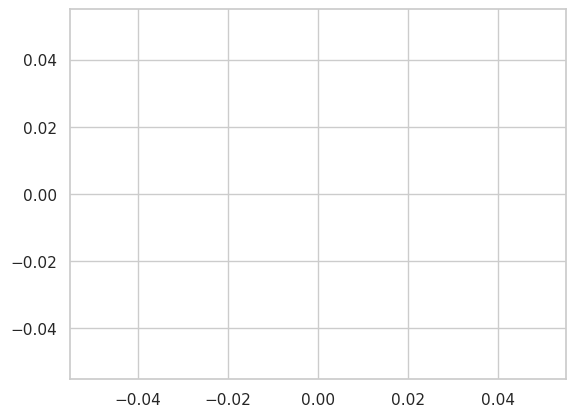

In [20]:
import seaborn as sns 

for ALG in ['Linear','Poisson','Zero-Inflated']:
    sns.scatterplot(data=df_full_res, y="TRUE county deaths", x=f"PRED county deaths {ALG}")

In [9]:
# df_full_res['PRED county deaths'].describe()

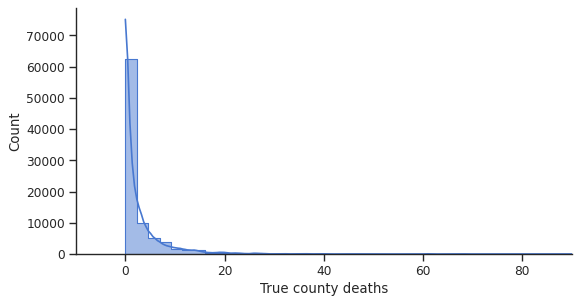

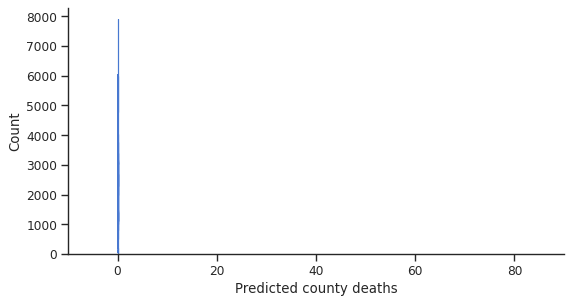

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='ticks', palette='muted') 
DPI = 80
FIGSIZE = (8,4)

plt.figure(figsize=FIGSIZE)
sns.histplot(df_full_res['TRUE county deaths'].values, bins=40, kde=True, element='step')
sns.despine()
plt.xlim((-10, 90))
plt.xlabel('True county deaths')
plt.gcf().set_dpi(DPI)
plt.show()

plt.figure(figsize=FIGSIZE)
sns.histplot(df_full_res['PRED county deaths'].values, bins=40, kde=True, element='step')
sns.despine()
plt.xlim((-10, 90))
plt.xlabel('Predicted county deaths')
plt.gcf().set_dpi(DPI)
plt.show()

# df_full_res['log_res'] = df_full_res['PRED county deaths'].apply(lambda x: np.log(x))

# plt.figure(figsize=FIGSIZE)
# sns.histplot(df_full_res['log_res'].values, bins=40, kde=True, element='step')
# sns.despine()
# plt.xlim((-20, 90))
# plt.xlabel('log( Predicted county deaths )')
# plt.gcf().set_dpi(DPI)
# plt.show()

## <font color=blue> b. _Metrics_ 
Average across cross-validation splits.

In [11]:
metric_sers = []

for alg in df_full_res.Algorithm.unique():
    for run in df_full_res.Run.unique():
        subdf = df_full_res[(df_full_res['Run']==run) & (df_full_res['Algorithm']==alg)]
        ser = get_metrics_ser(subdf, 
                              target_col=Y_COL,
                              pred_col=PRED_COL,
                              alg_col=alg,
                              naive_col=NAIVE_COL)

        metric_sers.append(ser)
    
df_run = pd.DataFrame(metric_sers)

# # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # #

df_melt = pd.melt(df_run, id_vars=['Algorithm'], 
                  value_vars=['MAE', 'MedAE', 'R-squared','MSE','relMAE'], 
                  var_name='Metric', value_name='Score')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1, style='whitegrid', palette='pastel') 
DPI = 70

# for metric in  ['MedAE', 'R-squared', 'relMAE']:
#     df_plot = df_melt[df_melt.Metric==metric]
#     sns.boxplot(df_plot, x='Algorithm',y='Score')   
#     plt.title(f'{metric}')
#     plt.xticks(rotation=45,ha='right')
#     plt.gcf().set_dpi(DPI)
#     plt.show()

for metric in  ['MedAE', 'R-squared', 'relMAE']:
    print(f'\n* {metric} *')
    for alg in df_full_res.Algorithm.unique():
        dff_melt = df_melt[(df_melt['Metric']==metric) & (df_melt['Algorithm']==alg)]
        print(f'== {alg} ==')
        print(f' Mean: {round(dff_melt.Score.mean(),3)}\n Median: {round(dff_melt.Score.median(),3)}')


* MedAE *
== Poisson ==
 Mean: 1.0
 Median: 1.0

* R-squared *
== Poisson ==
 Mean: -0.262
 Median: -0.259

* relMAE *
== Poisson ==
 Mean: 1.234
 Median: 1.238


In [12]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set(font_scale=1, style='ticks', palette='bright') 

# figsize = (8,6)
# alpha = 0.1
# sizes = 2
# linewidth = 0

# DPI = 80
# FIGSIZE = (6,6)

# # df = df_pred

# plt.figure(figsize=FIGSIZE)

# sns.scatterplot(data=df_full_res, x=Y_COL, y=PRED_COL, alpha=alpha, sizes=sizes, linewidth=linewidth, hue='Algorithm')
# # sns.scatterplot(data=df_full_res, x=Y_COL, y=PRED_COL, alpha=alpha, sizes=sizes, linewidth=linewidth)
# # sns.scatterplot(data=df_full_res, x=Y_COL, y=PRED_COL, alpha=alpha, sizes=sizes, linewidth=linewidth)

# sns.despine()
# plt.xlim((-10, 90))
# plt.gcf().set_dpi(DPI)
# plt.show()


# plt.show()

In [13]:
allDone()